To be run in CMSSW_10_2_3 with adding:
pip install --user joblib scikit-learn==0.20.4

Like v2 but with BTD trained in signal region

In [115]:
Mjj_selection = 1100.

SM_eff = 1e-2

def computeDiscriminatingVar(x):
    #out = x[:,-3]/x[:,1]+x[:,-2]/x[:,6]
    out = x[:,-6]+x[:,-3]
    out *= 100.0 #1e9
    return out

def computeDiscriminatingVar_str(l1, pt1, l2, pt2):
    out = 1e9*(l1/pt1+l2/pt2)
    return out

# def computeDiscriminatingVar(x):
#     out = 100*(x[:,-3]+x[:,-2])
#     return out*1e4

# def computeDiscriminatingVar_str(l1, l2):
#     out = 100*(l1+l2)
#     return out*1e4

# Imports

In [99]:
from __future__ import print_function

import h5py, os, sys, glob, datetime, time
sys.path.append('../lib')
from glob import glob
import numpy as np
import scipy as sp
from scipy.special import erf

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
from matplotlib.colors import LogNorm

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import joblib
import pickle
from prettytable import PrettyTable
import ROOT as rt
rt.PyConfig.IgnoreCommandLineOptions = True
rt.gROOT.SetBatch()
rt.gErrorIgnoreLevel = rt.kError

from histo_utilities import create_TH2D, create_TH1D, create_Canvas, make_effiency_plot, rootTH1_to_np
from progressBar import ProgressBar
from cebefo_style import cebefo_style

cebefo_style()


dnd = []

# Get the qcd sample for trainig

In [100]:
#file_dir = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/AE_Score/'
file_dir = '/afs/cern.ch/work/k/kiwoznia/vae_results/qcd_sqrtshatTeV_13TeV_PU40'
maxEvts = int(1e6)
pb = ProgressBar(maxEvts)

data_train = None
name_tag = 'qcd_sqrtshatTeV_13TeV_PU40'
#flist = glob(file_dir + name_tag + '*.h5')
flist = glob(file_dir + '/' + '*result.h5')
#print(flist)
for i_file, fname in enumerate(flist):
    f = h5py.File(fname, 'r')
    #print(f.keys())
    aux_evts = np.array(f.get('results'))
    aux_evts = aux_evts[aux_evts[:,0] > Mjj_selection]
    if data_train is None:
        print('Labels:')
        print(list(f.get('labels')))
        pb.show(0)
        data_train = aux_evts
    else:
        data_train = np.append(data_train, aux_evts, axis=0)

    pb.show(data_train.shape[0])

    if data_train.shape[0] > maxEvts:
        break
        

N_evts = (i_file+1) * 10000 # ??? data_train.shape[0]#
print(i_file)
print("\nnum evts: ", N_evts)
QCD_xsec = 8.73e-6 #mb
QCD_xsec *= 1e9 #fb # ??????
print('\nLuminosity used for training')
print('{:.2} fb^-1'.format(N_evts/QCD_xsec))
        

Labels:
['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j1RecoLoss', 'j1KlLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss']
[###################-]  97% - ETA:    1 s   1901

num evts:  19020000

Luminosity used for training
2.2e+03 fb^-1


In [101]:
#pickle.dump(data_train, open(file_dir + 'tmp_qcd_sqrtshatTeV_13TeV_PU40.pkl', 'wb'))

In [102]:
# data_train = pickle.load(open(file_dir + 'tmp_qcd_sqrtshatTeV_13TeV_PU40_SIDEBAND_MIAD.pkl', 'rb'))

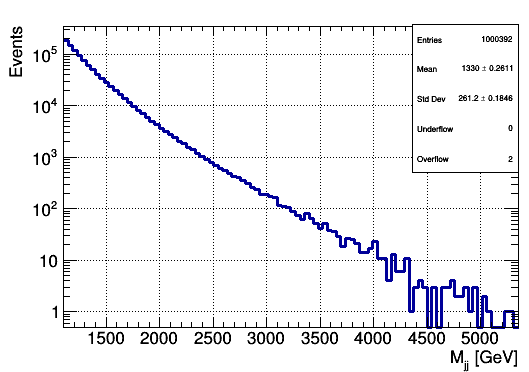

In [103]:
c = create_Canvas(size=(int(800/1.5),int(600/1.5)))
h_Mjj_side = create_TH1D(data_train[:,0], title='', axis_title = ['M_{jj} [GeV]','Events'], 
                binning=[100, Mjj_selection, 0.8*np.max(data_train[:,0])])

h_Mjj_side.Draw()
c.SetLogy()
c.Draw()

### Train the model to predict the cut

In [104]:
# Compute weights to make it mass agnostic
# hM = h_Mjj_side.Clone('hM')
# print(hM.FindBin(10000))
# scale = np.sqrt(hM.GetMaximum()*hM.GetMinimum(0))
# print(scale)
# hM.Scale(1./scale)

# weights = np.ones_like(data_train[:,0])
# for i, m in enumerate(data_train[:,0]):
#     weights[i] = 1./hM.GetBinContent(hM.FindBin(m))
#     if i%1000000 == 0:
#         print(i)

In [116]:
gbr_cut = GradientBoostingRegressor(loss='quantile', alpha=1-SM_eff,
                                n_estimators=250, max_depth=3,
                                learning_rate=.05, min_samples_leaf=30,
                                min_samples_split=30,
                                validation_fraction=0.5,
                                n_iter_no_change=5,
                                tol=1e-5,
                                verbose=2)


x = np.reshape(data_train[:,0], (-1,1))
y = computeDiscriminatingVar(data_train)
gbr_cut.fit(x, y, sample_weight=None);

date = datetime.date.today()
date_str = '{}{:02d}{:02d}'.format(date.year, date.month, date.day)
#joblib.dump(gbr_cut, '../models/gbr_cut_trained_{}.joblib'.format(date_str)) 

      Iter       Train Loss   Remaining Time 
         1           0.2718            1.11m
         2           0.2620            1.08m
         3           0.2537            1.09m
         4           0.2465            1.05m
         5           0.2405            1.01m
         6           0.2350           59.26s
         7           0.2303           58.14s
         8           0.2262           57.31s
         9           0.2225           56.54s
        10           0.2193           55.93s
        11           0.2165           55.37s
        12           0.2140           54.86s
        13           0.2118           54.56s
        14           0.2098           54.36s
        15           0.2079           54.03s
        16           0.2063           53.67s
        17           0.2049           53.48s
        18           0.2036           53.21s
        19           0.2024           52.88s
        20           0.2014           52.54s
        21           0.2004           52.38s
        2

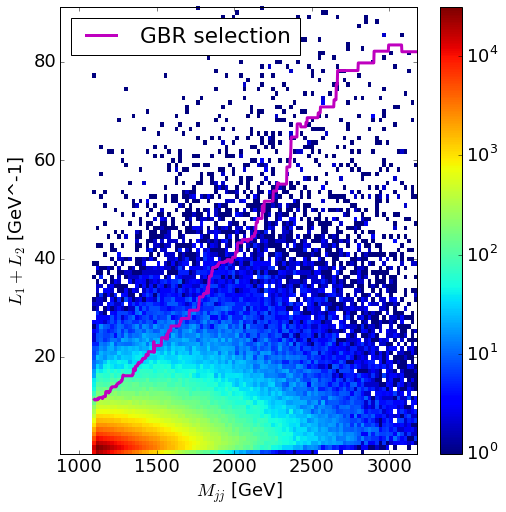

In [117]:
plt.figure(figsize=(8, 8))
x_min = Mjj_selection*0.8
x_max = np.percentile(x, 99.9)
plt.hist2d(x[:,0], y,
           range=((x_min , x_max), (np.min(y), np.percentile(y, 1e2*(1-1e-4)))), 
           norm=LogNorm(), bins=100,
           label='Side band data'
          )

xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-Mjj_selection))
plt.plot(xs, gbr_cut.predict(np.reshape(xs, (-1,1))), '-', color='m', lw=3, label='GBR selection')

plt.ylabel('$L_1 + L_2$ [GeV^-1]')
plt.xlabel('$M_{jj}$ [GeV]')
plt.colorbar()
plt.legend(loc='best')
plt.draw()

In [118]:
def getSelection(x_Mjj, x_loss):
    cut = gbr_cut.predict(np.reshape(x_Mjj, (-1,1)))
    return x_loss > cut

In [119]:
def plotMassSpectrum(mJJ_pass, mJJ_rej, title=''):
    h_a = create_TH1D(mJJ_pass, 
                      name='h_acc', title='Accepted',
                      binning=binning,
                      opt='overflow'
                     )
    h_a.SetLineColor(2)
    h_a.SetStats(0)
    h_a.Sumw2()
    h_r = create_TH1D(mJJ_rej, 
                      name='h_rej', title='Rejected',
                      axis_title=['M_{jj} [GeV]', 'Events'],
                      binning=binning,
                      opt='overflow'
                     )
    h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
    h_r.SetStats(0)
    h_r.Sumw2()

    c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-4, 0.2], draw_opt = 'E', title=title)
    c.pad1.SetLogy()
    c.pad2.SetLogy()

    c.pad2.cd()
    c.ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    c.ln.SetLineWidth(2)
    c.ln.SetLineStyle(7)
    c.ln.SetLineColor(8)
    c.ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)

    c.Draw()
    return c

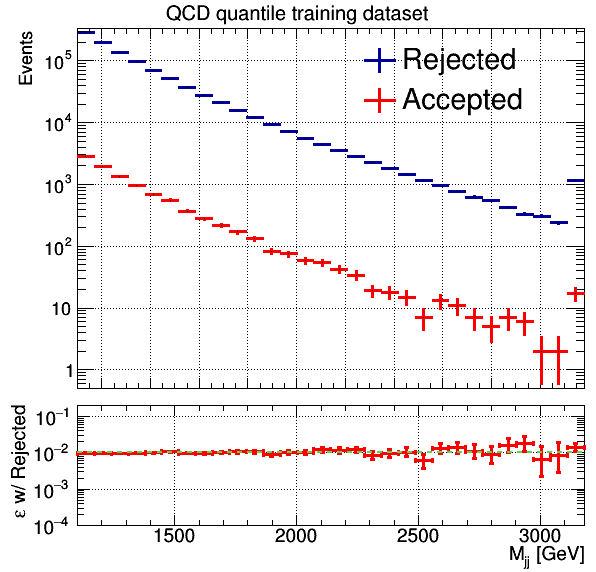

In [120]:
x = x.flatten()
binning=[30, Mjj_selection, np.percentile(x, 99.9)]

sel = getSelection(x, y)

c = plotMassSpectrum(x[sel], x[np.logical_not(sel)], 'QCD quantile training dataset')
h_a = c.h_list[1]
h_r = c.h_list[0]

# Define and test Hypotesis test

In [124]:
def HypotesisTets(h_a_bin_content, h_r_bin_content, eff, N_asymov = 10000, max_N_asymov = 1e7, show_hist=True):
    nu = eff*h_r_bin_content/(1-eff)

    probs_obs = sp.stats.poisson.pmf(h_a_bin_content.astype(np.int), nu)
    probs_obs = np.where(probs_obs < 1e-10, np.full_like(probs_obs, 1e-10), probs_obs)
    s_obs = np.sum(-np.log(probs_obs), axis=-1)
    print('S obs:', s_obs)

    N_worse = 0
    N_tot = 0
    loops = 0
    while N_worse < 25 and N_tot < max_N_asymov:
        loops += 1
        if loops > 1 and loops%10 == 0:
            print(N_tot, N_worse)
        if loops == 10:
            print('Increasing by a factor 5 the number of asymov per loop')
            N_asymov *=5
        o_asymov = np.random.poisson(nu, (N_asymov, nu.shape[0]))
        probs = sp.stats.poisson.pmf(o_asymov, nu)
        probs = np.where(probs < 1e-10, np.full_like(probs, 1e-10), probs)
        nll = -np.log(probs)
        s_asymov = np.sum(nll, axis=-1)

        N_worse += np.sum(s_asymov > s_obs)
        N_tot += N_asymov

        if max_N_asymov/N_tot < 25 and (N_worse * (max_N_asymov/N_tot) < 25):
            print('Will never have enough stat - giving up.')
            p_val = max(1, N_worse)/float(N_tot)
            return p_val

    print('Test stat reached after {} loops'.format(loops))

    p_val = max(1, N_worse)/float(N_tot)
    
    if show_hist:
        plt.figure()
        binContent, _, _ = plt.hist(s_asymov, label='Distribution assuming eff={:.1f}%'.format(100*eff))
        plt.plot([s_obs, s_obs], [0,np.max(binContent)], label='Observed')
        plt.legend(loc='best')
        plt.xlabel('Test statistic')
        plt.ylabel('Entries')

    return p_val

S obs: 100.66948662491554
Test stat reached after 1 loops


0.5947

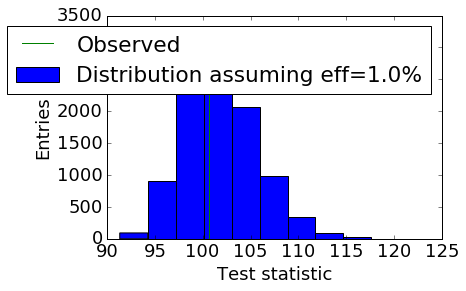

In [126]:
h_a_bin_content, _ = rootTH1_to_np(h_a)
h_r_bin_content, _ = rootTH1_to_np(h_r)
HypotesisTets(h_a_bin_content, h_r_bin_content, SM_eff, N_asymov=10000)

# Analyze signal region

In [112]:
sample_loc = {'qcdSigExt':'/afs/cern.ch/work/k/kiwoznia/vae_results/qcd_sqrtshatTeV_13TeV_PU40_EXT',
              'GtoWW1':'RSGraviton_WW_NARROW_13TeV_PU40_1p5TeV_img_stdnorm_bin',
              'GtoWW2':'RSGraviton_WW_NARROW_13TeV_PU40_2p5TeV_img_stdnor',
              'GtoWW3':'RSGraviton_WW_NARROW_13TeV_PU40_3p5TeV_img_stdnorm_bin',
              'GtoWW4':'RSGraviton_WW_NARROW_13TeV_PU40_4p5TeV_img_stdno',
              'AtoHZ':'AtoHZ_to_ZZZ_13TeV_PU40_img_stdnor',
              'GtoTTBroad':'RSGraviton_tt_BROAD_13TeV_PU40_img_stdnor',
              'GtoTTNarr':'RSGraviton_tt_NARROW_13TeV_PU40_img_stdnor'
             }

sample_label = {'qcdSigExt':r'QCD signal',
                'GtoWW1':r'$G(1.5 TeV)\to WW$',
                'GtoWW2':r'$G(2.5 TeV)\to WW$',
                'GtoWW3':r'$G(3.5 TeV)\to WW$',
                'GtoWW4':r'$G(4.5 TeV)\to WW$',
                'AtoHZ':r'A \to HZ \to ZZZ',
                'GtoTTBroad':r'G \to TT broad',
                'GtoTTNarr':r'G \to TT narrow'
               }

sample_label_ROOT = {'qcdSigExt':'QCD signal',
                'GtoWW1':'G(1.5 TeV) to WW$',
                'GtoWW2':'$G(2.5 TeV) to WW$',
                'GtoWW3':'$G(3.5 TeV) to WW$',
                'GtoWW4':'$G(4.5 TeV) to WW$',
                'AtoHZ':'A to HZ to ZZZ',
                'GtoTTBroad':'G to TT broad',
                'GtoTTNarr':'G to TT narrow'
               }

SM_samples = ['qcdSigExt']
BSM_samples = ['GtoWW1', 'GtoWW2', 'GtoWW3', 'GtoWW4','AtoHZ','GtoTTBroad', 'GtoTTNarr']

sample_nGenEvts = {'qcdSigExt': 1992*10000, # TODO: adapt numbers!
                   'GtoWW1': 90*10000,
                   'GtoWW2': 90*10000,
                   'GtoWW3': 92*10000,
                   'GtoWW4': 92*10000,
                   'AtoHZ': 92*10000,
                   'GtoTTBroad': 92*10000,
                   'GtoTTNarr': 92*10000
                  }

sample_xsec = {'qcdSigExt': 8734.0 #pb
              }

In [113]:
lumi_generated = sample_nGenEvts['qcdSigExt']/sample_xsec['qcdSigExt']
print('Lumi: {:.1f} pb^-1'.format(lumi_generated))

Lumi: 2280.7 pb^-1


### Get the data

In [114]:
data = {}
sample_eff = {}
table = PrettyTable()
table.field_names = ['Sample', 'Trg evts', 'Eff. trg [%]', 'VAE sel. evts', 'Eff VAE [%]']

for n, name_tag in sample_loc.iteritems():
    print(n)
    if True:#not 'GtoWW' == n[:-1]:
        filename = name_tag #.replace('_EXT3', '')
        flist = glob(file_dir + '/' + filename + '_results.h5')
        x = None
        pb = ProgressBar(len(flist))
        for i, fname in enumerate(flist):
            pb.show(i)
            f = h5py.File(fname, 'r')
            aux_evts = np.array(f.get('results'))
            aux_evts = aux_evts[aux_evts[:,0] > Mjj_selection]
            if x is None:
                x = aux_evts
            else:
                x = np.append(x, aux_evts, axis=0)

        # apply the dijet mass cut
        dVar = computeDiscriminatingVar(x)
        sel = getSelection(x[:,0], dVar)
        x = np.column_stack((x, dVar, sel))
        print(x.shape[0])
        sample_eff[n] = float(x.shape[0])/sample_nGenEvts[n]

        dt = [(str(s), '<f4') for s in list(f.get("labels")) + ['dVar']]
        dt += [('sel', '?')]
        data[n] = np.array(list(zip(*x.T)), dtype=dt)
    
    eff = '{:.2f}'.format(100*np.sum(data[n]['sel'])/float(data[n]['sel'].shape[0]))
    table.add_row([n, data[n]['sel'].shape[0], '{:.1f}'.format(100*sample_eff[n]), np.sum(data[n]['sel']), eff])
    
print(table)

qcdSigExt


ZeroDivisionError: integer division or modulo by zero

In [ ]:
x = np.reshape(data['qcdSide']['mJJ'], (-1,1))
y = computeDiscriminatingVar_str(data['qcdSide']['j1TotalLoss'], data['qcdSide']['j1Pt'], data['qcdSide']['j2TotalLoss'], data['qcdSide']['j2Pt'])

plt.figure(figsize=(8, 8))
x_min = Mjj_selection*0.8
x_max = np.percentile(x, 99.9)
plt.hist2d(x[:,0], y,
           range=((x_min , x_max), (np.min(y), np.percentile(y, 1e2*(1-1e-4)))), 
           norm=LogNorm(), bins=100,
           label='Side band data'
          )

xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-Mjj_selection))
plt.plot(xs, gbr_cut.predict(np.reshape(xs, (-1,1))), '-', color='m', lw=3, label='GBR selection')

plt.ylabel('$L_1/P^1_T + L_2/P^2_T$ [GeV^-1]')
plt.xlabel('$M_{jj}$ [GeV]')
plt.colorbar()
plt.legend(loc='best')
plt.draw()

### Define utilitities

In [ ]:
def plotMassSpectrum_wSig(h_r, h_a, h_a_sig, name_BSM, lumi_text, p_val):
    h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
    h_r.SetStats(0)
    h_r.Sumw2()
    h_r.SetLineWidth(2)
    
    h_a.SetLineColor(2)
    h_a.SetStats(0)
    h_a.Sumw2()
    h_a.SetLineWidth(2)
    
    h_a_sig.SetFillStyle(3001)
    h_a_sig.SetFillColor(8)
    h_a_sig.SetLineWidth(0)

    c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-3, None], draw_opt = 'E')
    c.pad1.SetLogy()
    c.pad1.cd()
    h_a_sig.Draw('SAME')
    c.leg.AddEntry(h_a_sig, 'Acc. '+sample_label_ROOT[name_BSM], 'f')
    
    latex = rt.TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.SetTextAlign(31)
    t = c.pad1.GetTopMargin()
    r = c.pad1.GetRightMargin()
    latex.DrawLatex(1-r, 1-0.85*t, lumi_text)

    c.pad2.SetLogy()
    c.pad2.cd()
    c.ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    c.ln.SetLineWidth(2)
    c.ln.SetLineStyle(7)
    c.ln.SetLineColor(6)
    c.ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    
    latex.SetTextSize(0.1)
    latex.SetTextAlign(13)
    l = c.pad2.GetLeftMargin()
    t = c.pad2.GetTopMargin()
    latex.DrawLatex(l*1.1, 1-2*t, 'p-value: {:.1f} %'.format(100*p_val))

    c.Draw()
    return c

## Find the p-value as a function of xsec

In [ ]:
lumi = 2000 #pb^-1

N_asymov = 10000
N_exp_per_xsec = 5

In [ ]:
dic_p_val = {}
rt.gROOT.SetBatch(True)

In [ ]:
for name_BSM in BSM_samples:
    print('\n\n'+name_BSM)
    dic_p_val[name_BSM] = []
    for xsec_BSM in np.logspace(-5, -4, 2): 
        print('xsec BSM {:.1e} pb'.format(xsec_BSM))
        lumi_text = '{:.1f} fb^{{-1}} (14 TeV), '.format(1e-3*lumi) + sample_label_ROOT[name_BSM] + ' ({:.2} pb)'.format(xsec_BSM)

        p_val_test = []
        for i_exp in range(N_exp_per_xsec):
            print('Experiment:', i_exp)
            d_obs = np.zeros((0,2))

            sample_xsec[name_BSM] = xsec_BSM
            for n in SM_samples + [name_BSM]:
                nExpEvts = lumi*sample_xsec[n]*sample_eff[n]
                nEvts = np.random.poisson(nExpEvts)
                if data[n]['mJJ'].shape[0] < nEvts:
                    print('[WARNING] ' + n + ' re-use factor = {:.2f}'.format(float(nEvts)/data[n]['mJJ'].shape[0]))
                evtsIdx = np.random.randint(0, data[n]['mJJ'].shape[0], size=(nEvts,))

                d_aux = np.column_stack((data[n]['mJJ'][evtsIdx], data[n]['sel'][evtsIdx]))
                d_obs = np.concatenate((d_obs, d_aux))

            h_a = create_TH1D(d_obs[:, 0][d_obs[:,1].astype(np.bool)], 
                                 name='h_acc', title='Accepted',
                                 binning=binning,
                                 opt='overflow'
                                )

            h_r = create_TH1D(d_obs[:, 0][np.logical_not(d_obs[:,1]).astype(np.bool)], 
                                 name='h_rej', title='Rejected',
                                 axis_title=['M_{jj} [GeV]', ''],
                                 binning=binning,
                                 opt='overflow'
                                )
            h_r.SetYTitle('Events / {:.0f} GeV'.format(h_r.GetBinWidth(1)))

            h_a_bin_content, _ = rootTH1_to_np(h_a)
            h_r_bin_content, _ = rootTH1_to_np(h_r)
            p_val = HypotesisTets(h_a_bin_content, h_r_bin_content, SM_eff, N_asymov = N_asymov, show_hist=False)
            p_val_test.append(p_val)

            if i_exp > 3 and np.max(p_val_test) == 0:
                break

            if i_exp == 0:
                h_a_sig = create_TH1D(d_obs[-nEvts-1:, 0][d_obs[-nEvts-1:, 1].astype(np.bool)], 
                                     name='h_acc', title='Accepted',
                                     binning=binning,
                                     opt='overflow'
                                    )
                c = plotMassSpectrum_wSig(h_r, h_a, h_a_sig, name_BSM, lumi_text, p_val)
                fig_name = 'fig/'
                fig_name += name_BSM + '{:1.2e}'.format(xsec_BSM) + 'pb' + '_L' + str(lumi) + 'pb-1_wEff'
                c.SaveAs(fig_name + '.png')
                #c.Draw()
                
        aux = [xsec_BSM] + list(np.percentile(p_val_test, [2.5, 16, 50, 84, 97.5]))
        dic_p_val[name_BSM].append(aux)

# Make the p-value plot

In [ ]:
sample_col = {
              'GtoWW1':'b',
              'GtoWW2':'g',
              'GtoWW3':'r',
              'GtoWW4':'m',
              'AtoHZ':'v',
              'GtoTTBroad':'s',
              'GtoTTNarr':'c'
             }

In [ ]:
matplotlib.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(8,8))

for n, val_aux in dic_p_val.iteritems():
    val_aux = np.array(val_aux)
    x_sec = val_aux[:, 0]
    quant = val_aux[:, 1:]
    
    ax1.plot(x_sec, quant[:, 2], color=sample_col[n], label=sample_label[n])
    print(x_sec, quant[:,2])
    ax1.fill_between(x_sec, quant[:, 1], quant[:, 3], color=sample_col[n], alpha = 0.1, lw=0)
#     ax1.fill_between(x_sec, quant[:, 0], quant[:, 4], color=sample_col[n], alpha = 0.1, lw=0)
    
    
plt.xscale('log')
plt.xlabel('Cross section [pb]')
plt.yscale('log')
plt.ylabel('p-value')
plt.ylim(1 - erf(5.5/np.sqrt(2)), 1)
plt.legend(loc='upper right')
ax2 = ax1.twinx()
for i in range(1, 6):
    p = 1 - erf(i/np.sqrt(2))
    ax2.plot([x_sec[0], x_sec[-1]], 2*[p], '--', color='grey')
plt.yscale('log')
ax2.set_yticks(1 - erf(np.arange(1,6)/np.sqrt(2)))
ax2.set_yticklabels(['{}$\sigma$'.format(i) for i in range(1,6)])
ax2.tick_params(axis='y', labelcolor='grey')

fig.savefig('fig/' + 'pValueScan_L' + str(lumi) + 'pb-1.png', bbox_inches='tight')